# 准备

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # 4改为0

In [2]:
# 在执行用户代码前，重新装入（原有）软件的扩展和模块。
%reload_ext autoreload
# 装入所有 %aimport 不包含的模块。
%matplotlib inline
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from joblib import load, dump
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from torchvision import models as md
from torch import nn
from torch.nn import functional as F
import re
import math
import collections
from functools import partial
from torch.utils import model_zoo
from sklearn import metrics
from collections import Counter
import json
from efficientnet_pytorch import EfficientNet
from utils import *

# torch.cuda.device_count()  # 当前系统有2个GPU

/home/user02/anaconda3/envs/py36/lib/python3.6/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


In [3]:
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
SEED = 2019
seed_everything(SEED)

In [4]:
current_time = '1202_14-10-24'  # get_BJ_time()
print(current_time)  # 原为0811_17-10-11

1202_14-10-24


# Reading data and Basic EDA(Exploratory Data Analysis)

Here I am going to open the dataset with pandas, check distribution of labels.

In [5]:
# 将2015的数据(35126张)作为训练集，2019原始训练集(3662张)作为验证集
df_2015 = pd.read_csv('../input/aptos-data-split/df_2015_raw_sigmaX10.csv')
df_2019 = pd.read_csv('../input/aptos-data-split/df_2019_sigmaX10.csv')

df = pd.concat([df_2015, df_2019], sort=False).reset_index(drop=True) # merge train val together
df['is_valid'] = [False]*df_2015.shape[0] + [True]*df_2019.shape[0]

# 将2019原始测试集作为测试集
test_df = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')

In [6]:
# 32改为12,不然lr_find()没结果无法绘图，训练一开始就会提示GPU内存不足
# 注意,不同系列的模型,占用的显存是不一样的,b5可以取12~14,b4可以取16
bs = 12 #smaller batch size is better for training, but may take longer
sz = 256  # get model input size
# sz = EfficientNet.get_image_size(model_name)  # get model input size
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=0, max_zoom=1.2, max_warp=0)

In [7]:
# 创建用于存储数据的列表类ItemList，这里是针对图像的图像(标签)列表类ImageList（ImageList是ItemList的子类）
# 生成ItemList实例的工厂类方法是使用panda.DataFrame对象提供数据标签的from_df()
data = (ImageList.from_df(df=df,path='./',cols='path')
        .split_from_df("is_valid")  # 对数据集拆分，标记列即is_valid列
        .label_from_df(cols='diagnosis',label_cls=FloatList)   # 根据指定的标签列'diagnosis'，对数据进行标记；指明Label Class为FloatList类型
        .transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros')   # resize_method=ResizeMethod.SQUISH 压扁到指定尺寸
        .databunch(bs=bs,num_workers=0)  # DataBunch是fastai中读取数据最基本的类，其针对不同的任务将数据集处理成合适的形式，以便送入learner进行训练。
        .normalize(imagenet_stats)  # imagenet_stats 函数会根据 ImageNet 预训练模型的训练方式归一化输入图像
       )
data

ImageDataBunch;

Train: LabelList (35126 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
0.0,0.0,0.0,0.0,1.0
Path: .;

Valid: LabelList (3662 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
2.0,4.0,1.0,0.0,0.0
Path: .;

Test: None

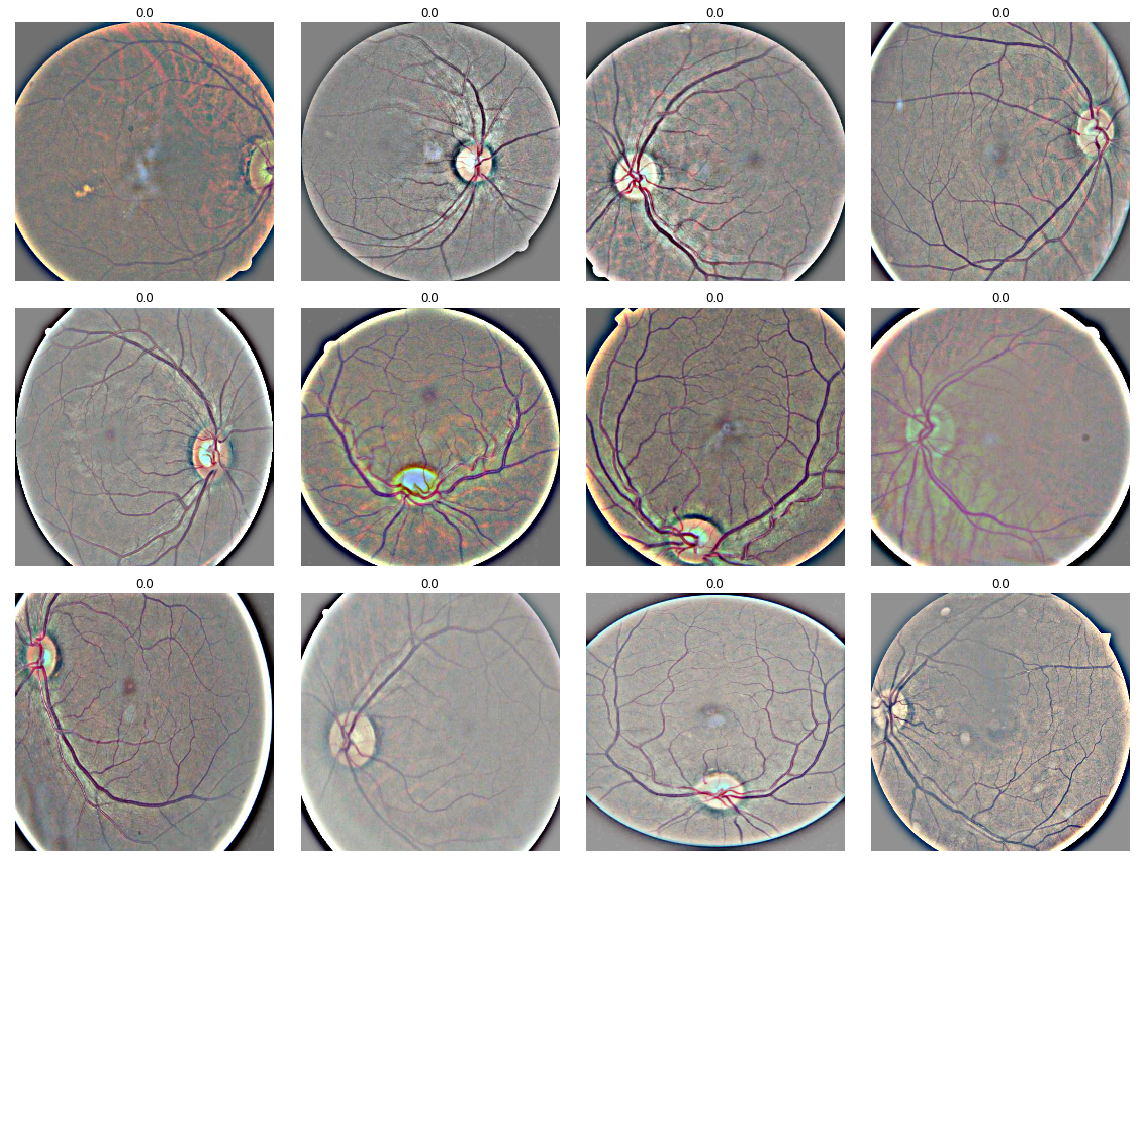

In [8]:
# 显示一个批量的样本，16张分成4*4个方格显示
data.show_batch()

In [9]:
df_2019 = pd.read_csv('../input/aptos-data-split/df_2019_cv.csv')
data_2019 = (ImageList.from_df(df=df_2019,path='./',cols='path')
        .split_from_df("is_valid")
        .label_from_df(cols='diagnosis',label_cls=FloatList) 
        .transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') 
        .databunch(bs=bs,num_workers=4) 
        .normalize(imagenet_stats)  
       )
data_2019

ImageDataBunch;

Train: LabelList (2929 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
2.0,1.0,0.0,4.0,0.0
Path: .;

Valid: LabelList (733 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: FloatList
4.0,0.0,1.0,0.0,2.0
Path: .;

Test: None

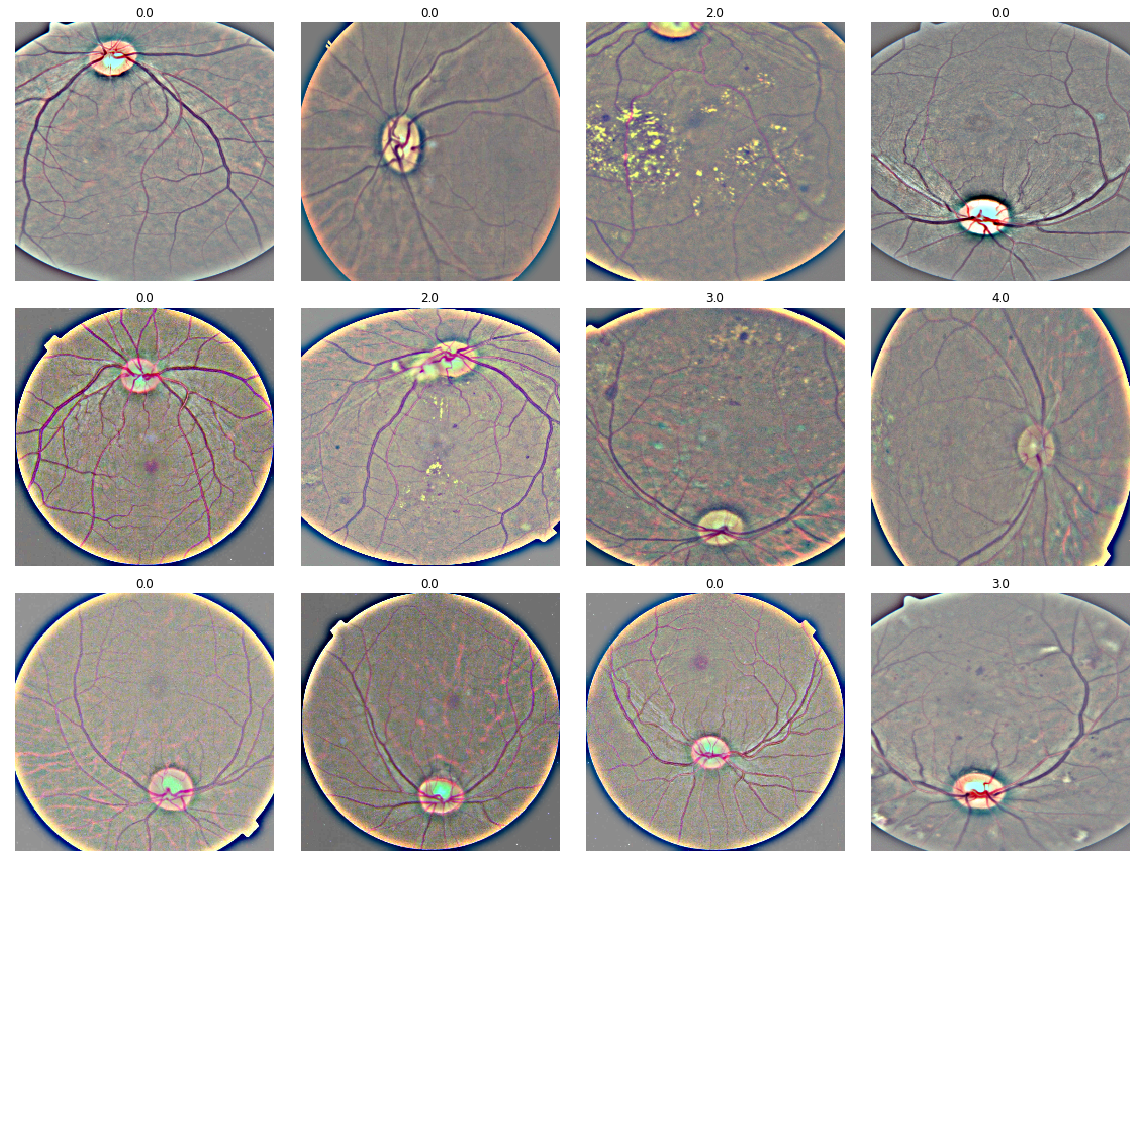

In [11]:
data_2019.show_batch()
#data_2019.show_batch(rows=3, figsize=(10,8), ds_type=DatasetType.Valid)   # Show a batch of data in ds_type on a few rows.

# Training (Transfer learning)

The Kaggle competition used the Cohen's quadratically weighted kappa so I have that here to compare. This is a better metric when dealing with imbalanced datasets like this one, and for measuring inter-rater agreement for categorical classification (the raters being the human-labeled dataset and the neural network predictions). Here is an implementation based on the scikit-learn's implementation, but converted to a pytorch tensor, as that is what fastai uses.

In [12]:
def qk(y_pred, y):
    return torch.tensor(cohen_kappa_score(torch.round(y_pred), y, weights='quadratic'), device='cuda:0')

## EfficientNet 

In [13]:
# 导入EfficientNet b5系列模型的初始模型
model_name = 'efficientnet-b5'
model = EfficientNet.from_pretrained(model_name, num_classes=1)

Loaded pretrained weights for efficientnet-b5


## 阶段一训练(用于5折训练)

In [14]:
# 创建学习器，采用2015+2019的数据集
learn = Learner(data, 
                model, 
                metrics = [qk],
                callback_fns=[partial(EarlyStoppingCallback, min_delta=0, patience=3)],
                model_dir = '../output/models/')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 9.12E-04


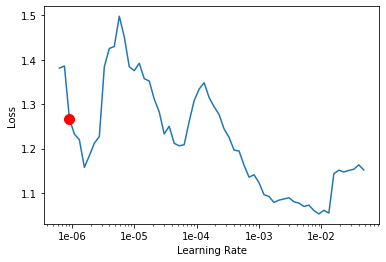

In [14]:
# 查找最佳学习速率
# Explore lr from `start_lr` to `end_lr` over `num_it` iterations in `learn`. If `stop_div`, stops when loss diverges.
learn.lr_find()  # 拿训练集35126张，如果批大小12张/批，共2927批（2927*12=35124）,实际跑少量样本就会结束查找过程
learn.recorder.plot(suggestion=True)

In [15]:
# 训练
model_save_name = "{}_{}_stage1".format(model_name, current_time)
# min_grad_lr = learn.recorder.min_grad_lr
# learn.fit_one_cycle(20, min_grad_lr, callbacks=[SaveModelCallback(learn, every='improvement', name=model_save_name)])
# 自动搜索到的学习率效果不好，观察学习率曲线，选用指定的固定值
learn.fit_one_cycle(20, 1e-3, callbacks=[SaveModelCallback(learn, every='improvement', name=model_save_name)])
print("Model save as:", model_save_name)

Better model found at epoch 0 with valid_loss value: 0.4471942186355591.
Better model found at epoch 1 with valid_loss value: 0.44010981917381287.
Better model found at epoch 2 with valid_loss value: 0.3745289146900177.
Epoch 6: early stopping
Model save as: efficientnet-b5_1202_14-10-24_stage1


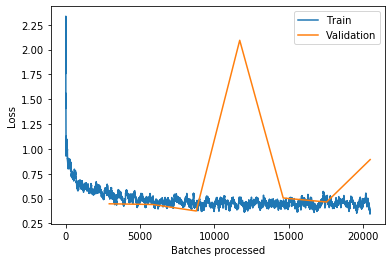

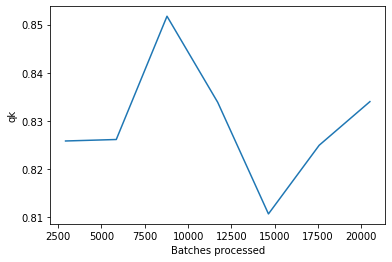

In [16]:
# 查看训练过程
learn.recorder.plot_losses()  # 损失曲线
learn.recorder.plot_metrics()  # 指标曲线

## 阶段二训练(用于本笔记后续分析)

In [15]:
# 第二次训练，采用2019数据
learn = Learner(data_2019, 
                model, 
                metrics = [qk],
                callback_fns=[partial(EarlyStoppingCallback, min_delta=0, patience=3)],
                model_dir = '../output/models/')

learn.data.add_test(ImageList.from_df(test_df,
                                      '../input/aptos2019-blindness-detection',
                                      folder='test_images_ben_preprocessing_sigmaX10',
                                      suffix='.png'))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.91E-05


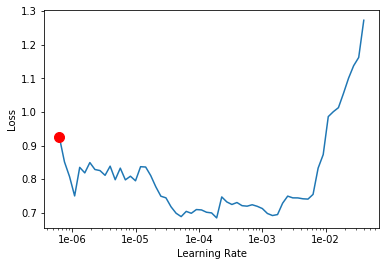

In [18]:
# 加载阶段一最佳模型,在此基础上进行阶段二的训练
learn.load(model_save_name)

# 查找最佳学习率
# Explore lr from `start_lr` to `end_lr` over `num_it` iterations in `learn`. If `stop_div`, stops when loss diverges.
learn.lr_find()  # 对b5系列按三种学习率-3,-4,-5训练,结果发现1e-4效果最好
learn.recorder.plot(suggestion=True)

In [20]:
# 训练
model_save_name = "{}_{}_stage2".format(model_name, current_time)
# min_grad_lr = learn.recorder.min_grad_lr
learn.fit_one_cycle(20, 1e-4, callbacks=[SaveModelCallback(learn, every='improvement', name=model_save_name)])
print("Model save as:", model_save_name)

Better model found at epoch 0 with valid_loss value: 0.25779271125793457.
Better model found at epoch 1 with valid_loss value: 0.24785925447940826.
Better model found at epoch 3 with valid_loss value: 0.2327674925327301.
Better model found at epoch 6 with valid_loss value: 0.23050372302532196.
Better model found at epoch 7 with valid_loss value: 0.22900643944740295.
Better model found at epoch 8 with valid_loss value: 0.22878101468086243.
Better model found at epoch 9 with valid_loss value: 0.2206571251153946.


/home/user02/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:600: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


Epoch 13: early stopping
Model save as: efficientnet-b5_1202_14-10-24_stage2


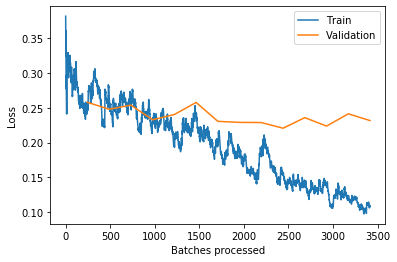

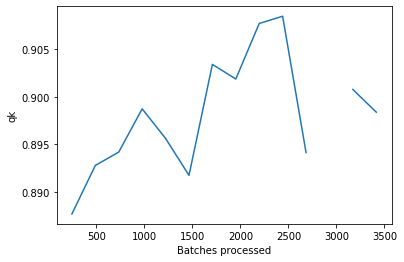

In [21]:
# 查找训练过程
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [21]:
# 加载阶段二最佳模型
learn.load(model_save_name);

# Optimize the Metric
Optimizing the quadratic kappa metric was an important part of the top solutions in the previous competition. Thankfully, @abhishek has already provided code to do this for us. We will use this to improve the score.

In [22]:
import scipy as sp

In [23]:
class OptimizedRounder(object):
    """
    Optimize threshold coefficients. 优化阈值系数
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        """
        Customized loss function.
        
        :param coef: list, shape=[4]
            Threshold.
        :param X: list, shape=[5]
            Prediction.
        :param y: list, shape=[5]
            Golden label.
        """
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        
        # Cohen's kappa: a statistic that measures inter-annotator agreement.
        ll = metrics.cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        """
        :param X: list, shape=[5]
            Prediction. 预测结果
        :param y: list, shape=[5]
            Golden label. 标签
        """
        # new function with partial application of the given arguments and keywords.
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        # Minimization of scalar function of one or more variables.
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')
        print(-loss_partial(self.coef_['x']))

    def predict(self, X, coef):
        """
        :param X: list, shape=[5]
            Prediction.
        :param coef: list, shape=[4]
            Threshold.
        """
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [24]:
# 校正分类阈值
# Return predictions and targets on `ds_type` dataset.
valid_preds = learn.get_preds(ds_type=DatasetType.Valid)  # 计算验证集的预测值
optR = OptimizedRounder()
optR.fit(valid_preds[0],valid_preds[1])  # 预测数据与标签数据
coefficients = optR.coefficients()
print(coefficients)  # 原0.9265277309777393, [0.572973 1.476506 2.217975 3.03685 ]

0.9103926586363711
[0.516043 1.557263 2.427341 3.394521]


# Error Analysis 错误分析

In [25]:
valid_pred = optR.predict(valid_preds[0], [0.5, 1.5, 2.5, 3.5])  # 验证集的预测值按指定阈值归类
cm = confusion_matrix(valid_pred,valid_preds[1])  # 混淆矩阵

Confusion matrix, without normalization
[[360   5   1   0   0]
 [  8  26  14   0   0]
 [  0  44 153   8  22]
 [  0   0  28  22  22]
 [  0   0   0   1  19]]


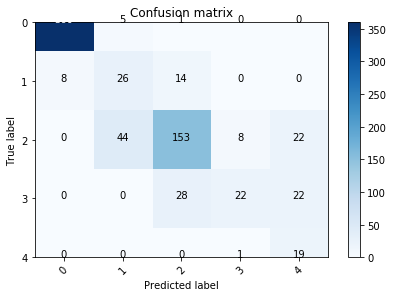

In [26]:
# 绘制混淆矩阵
plot_confusion_matrix(cm, classes=range(5), normalize=False)

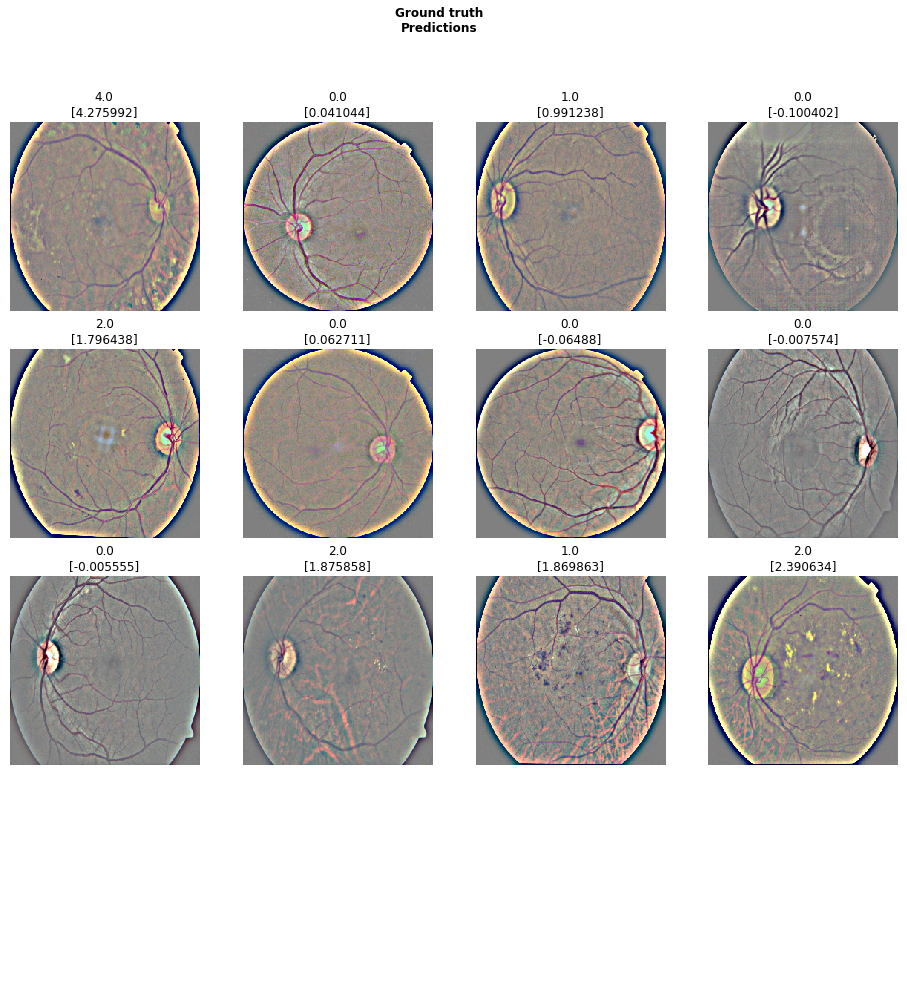

In [27]:
# 显示一个batch_size的预测结果
# https://docs.fast.ai/basic_train.html#Learner.show_results
# text number on the top is the ground truth, or the target label, the one in the middle is the prediction
learn.show_results(rows=4)

# Submission 提交

In [28]:
preds,y = learn.get_preds(DatasetType.Test)   # 预测测试集(1928张，121轮)，概率值存入preds
tst_pred = optR.predict(preds, coefficients)  # 预测分类，由preds传入预测值，coefficients传入分类阈值，tst_pred返回分类号
test_df.diagnosis = tst_pred.astype(int)  # 由float32转为int型，存入test_df.diagnosis字段

In [29]:
save_filename = '{}_submition.csv'.format(model_save_name)
test_df.to_csv(save_filename, index=False)  # 预测结果存入文件efficientnet-b4_1202_14-10-24_stage2_submition.csv
print (save_filename, 'done')

efficientnet-b5_1202_14-10-24_stage2_submition.csv done


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fef347af940>]], dtype=object)

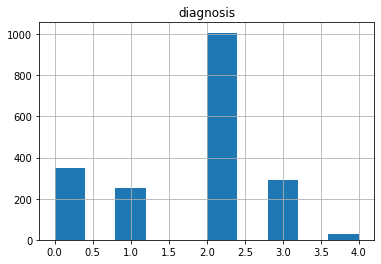

In [30]:
#2
test_df.hist()  # 默认绘制首个数字列的直方图，即预测分类直方图
# test_df["diagnosis"].value_counts("True").plot(kind="bar")  # 指定列直方图，按百分数显示，降序排列

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fef346c74e0>]], dtype=object)

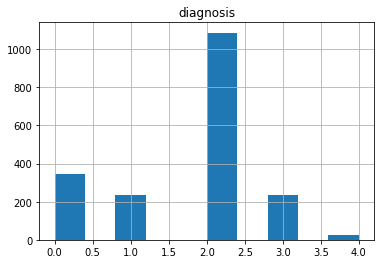

In [31]:
#2
test_df.diagnosis = optR.predict(preds, [0.5, 1.5, 2.5, 3.5])  # 按指定阈值分类
test_df.hist()

In [22]:
# 以下代码中的0.806.csv应该是某次训练的测试结果,读入加以对比用的
# pd.read_csv("0.806.csv").hist()